# Linear Models

This chapter combines contents from Raschka, chapter 3, and Geron, chapters 3 and 4.

In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.metrics import roc_curve, f1_score, confusion_matrix, precision_recall_curve

import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

%matplotlib inline

# Linear regression

We have seen in chapter 7 that Adaline uses linear combinations of the features to minimize its cost function, the sum of squared errors (SSE). This is equivalent to minimizing the mean squared error (MSE) or root mean squared error (RMSE) that we know from ordinary least squares (OLS) regressions.

The prediction for the linear regression is

\begin{align}
\hat{y}=h_{\theta}(\mathbf{x})=\theta^T\mathbf{x}
\end{align}

## Closed form solution

We can estimate a linear regression model using machine learning techniques or by solving the model in closed form, where, given the feature matrix $X$ and the target vector $y$, the estimator of the parameter vector $\theta$ is
\begin{align}
\hat{\theta}=\big(X^TX\big)^{-1}X^Ty
\end{align}

We simulate some data using one feature and a random error term.

In [2]:
np.random.seed(42)

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

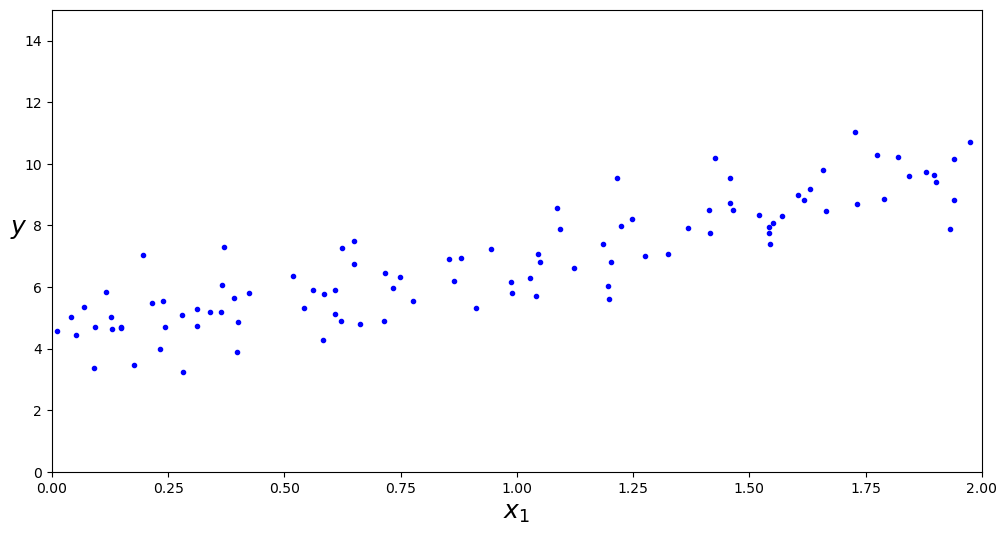

In [3]:
plt.figure(figsize=(12,6))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Matrix operations provide the estimate directly.

In [4]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

The estimated parameters can then be used to predict target values for any given value of the feature.

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

The regression line shows the predicted values.

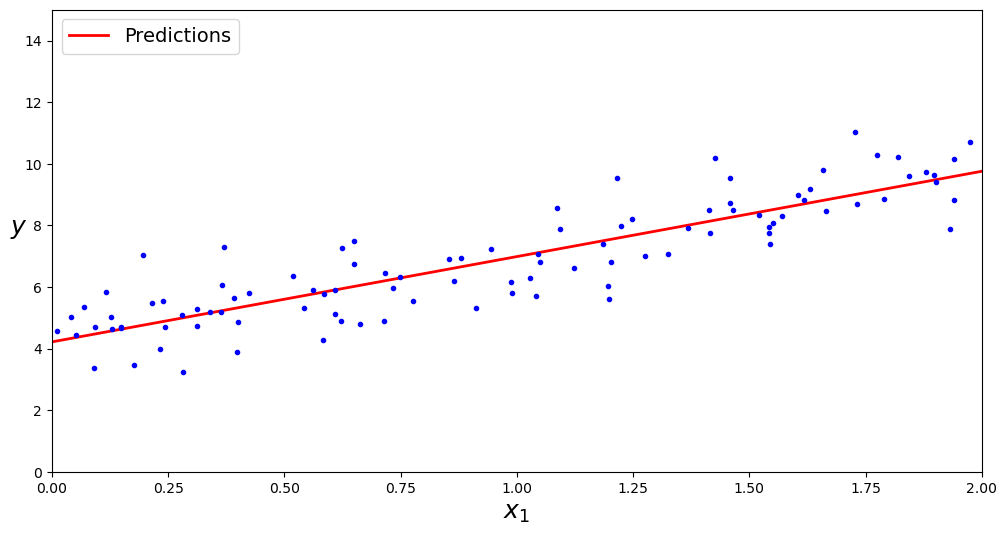

In [6]:
plt.figure(figsize=(12,6))
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

The linear regression model, using the closed form solution, is available in `sklearn` as the class `LinearRegression`. The following code is equivalent to what we did above.

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

### Computational Complexity

While the closed form solution is theoretically simple, it can become quite time consuming if there is a large number of features. The matrix inversion is computationally costly with a complexity of $O(m^{2.4})$ to $O(m^3)$, meaning that a doubling of the number of features increases the time needed for the computation by a factor of roughly $2^{2.4}=5.3$ to $2^3=8$. The computational complexity can become a problem if we have thousands or hundreds of thousands of features.

## Linear regression via Gradient Descent

Since linear regression is equivalent to the Adaline, we can use Gradient Descent (GD) again. We will not consider batch gradient descent, which uses the whole training set to update the parameter estimates, again here. Instead, we will focus on alternative gradient descent optimizers.

Batch gradient descent can be difficult or impossible if the training data is very large. In that case, we can instead use only part of the training data to determine the update to the parameters.

## Stochastic Gradient Descent

__Stochastic Gradient Descent (SGD)__ repeatedly updates the parameters based on one randomly chosen instance drawn from the training data. This eliminates the problem with __Batch Gradient Descent__ if the data is very large. However, because of its stochastic nature, the parameters will never converge to the optimal values but instead keep changing after reaching values close to the optimum.

<center>

<img src="images/geron4_9.png" align="center" width="600" />
</center>
(Geron, Fig 4-9)

There is another advantage to SGD compared to GD: if the cost function is not convex (as it is for linear regression), e.g., as in the figure below, GD may get stuck in a local optimum that is worse than the global optimum. SGD makes it more likely to escape local optima and therefore to ultimately arrive near the global optimum.

<center>

<img src="images/geron4_6.png" align="center" width="600" />
</center>
(Geron, Fig 4-6)

In order to benefit from the avoidance of local optima while ending up close to the global optimum, i.e., without too large changes to the parameters after arriving near the global optimum, it is common to successively decrease the learning rate during the optimization. This method is called __Simulated Annealing__. The function determining the variation of the learning rate over time is called the __learning schedule__.

`sklearn` offers the class `SGDRegressor`, which implements SGD using a learning schedule. The parameter `learning_rate` can be set to choose among several learning schedules.

`eta0` is the initial learning rate, `max_iter` the maximum number of epochs. Instead of always using `max_iter` epochs, we would like the learner to stop when there is no substantive improvement to the cost function anymore. We do so by setting `tol`, the tolerance, and `n_iter_no_change`. The learning will stop if the cost function has not improved by more than `tol` for `n_iter_no_change` epochs.

In [8]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, n_iter_no_change=5, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

The estimated parameters are close to, but not identical to, those obtained using a closed form solution or Batch Gradient Descent.

In [9]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

## Mini-batch gradient descent

Mini-batch gradient descent can be viewed as a method in between SGD and Batch Gradient Descent. In each step, there is a random draw of multiple samples from the training data, and the parameters are updated based on the realization of the cost function for that __mini-batch__. Mini-batch gradient descent is not directly available in `sklearn`, though the `partial_fit` method available for some learners can be used to achieve something similar.

What follows is an implementation of mini-batch GD.

In [10]:
theta_path_mgd = []
n_iterations = 50
minibatch_size = 20
n = 100
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization
t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(n)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, n, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [11]:
theta

array([[4.25214635],
       [2.7896408 ]])

The figure shows the learning paths for the batch, mini-batch, and stochastic GD, based on the same data.

<center>

<img src="images/gradient_descent_paths_plot.png" align="center" width="1200" />
</center>

## The Bias/Variance Tradeoff
The __generalization error__ (also called __out-of-sample error__) is a measure of the errors made by an algorithm when predicting target values for samples outside the training data. The generalization error is the sum of three errors:

* __Bias__: due to wrong assumptions, e.g., we assume the wrong functional form or do not use some features that actually are important. A high bias is associated with an __underfitting__ of the training data.
* __Variance__: due to excessive sensitivity to the training data, i.e., random fluctuations in the training data substantively affect the predictions. The variance will be high if we allow for too many degrees of freedom, e.g., too many features or a too flexible functional form (__overfitting__).
* __Irreducible error__: due to noise in the data itself, e.g., measurement errors.

If we make a model more flexible/complex, the bias will usually be reduced at the expense of the variance. The goal is to find the optimal tradeoff between the two.

<center>

<img src="images/03_07.png" align="center" width="1200" />
</center>
(Raschka, ch 3)

# Regularized models

If the number of potentially relevant features is large relative to the number of samples, overfitting is an important concern. Regularization imposes penalties on the weights of the features with the objective of retaining only those predictors that substantively contribute to the prediction.

When we regularize models, it is important to distinguish between two cost functions:

* The cost function used in the learning process contains a term immediately determined by the estimated parameter values $\hat{\theta}$ as the goal is to reduce overfitting of the training data.
* The cost function relevant for the test data is the same as the one used for a model without regularization, e.g., in the case of a linear regression, the mean squared error.

There are cases other than regularized models where we might use different cost functions for the learning process and the evaluation of the performance on the test data. It is important that the cost function used for the learning process facilitates it. E.g., if we use gradient descent, the function should have easily computed derivatives that enable the adjustment to the parameters, whereas those derivatives do not matter when we evaluate the test performance.

## Ridge regression

The Ridge regression is a regularized form of the linear regression. Its cost function is
\begin{align}
J(\theta)=MSE(\theta)+\alpha\frac{1}{2}\sum_{j=1}^m\theta_j^2
\end{align}
The __regularization term__ $\alpha\sum_{j=1}^m\theta^2$ penalizes large regression parameters, i.e., it forces the parameters downward compared to an unregularized model. Note that the sum doesn't include $\theta_0$, the bias term corresponding to the constant in the regression. The hyperparameter $\alpha$ determines the extent of regularization: the extreme case of $\alpha=0$ is equivalent to an OLS regression, whereas all parameters will be forced toward 0 as $\alpha\to\infty$.

For the vector of feature weights defined as $\mathbf{w}=(\theta_1\dots\theta_m)^T$, the regularization term can be written as $\alpha\frac{1}{2}(\lVert\mathbf{w}\rVert_2)^2$, where $\lVert\cdot\rVert_2$ is the $\ell_2$ norm. Thus, when applying Gradient Descent, we simply add $\alpha\mathbf{w}$ to the gradient vector $\nabla_{\theta}MSE(\theta)$.

### Closed-form and Gradient Descent

Ridge regression can be estimated using either closed-form or GD. The closed-form solution is

\begin{align}
\hat{\theta}=\big(\mathbf{X}^TX+\alpha\mathbf{A}\big)^{-1}\mathbf{X}^T\mathbf{y}
\end{align}
where $\mathbf{A}$ is the $m\times m$ identity matrix.

The `sklearn` class `Ridge` offers several choices for the parameter `solver`, including `cholesky` for the closed-form solution, and `sag`, which is a variant of Stochastic Gradient Descent.

We will simulate some data as a linear function of one feature plus noise.

In [12]:
np.random.seed(42)
n = 20
X = 3 * np.random.rand(n, 1)
y = 1 + 0.5 * X + np.random.randn(n, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In this example, we set the hyperparameter `alpha` to 1. The estimates show that the two approaches both yield nearly the same result.

In [13]:
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [14]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55072189]])

We can also use the `SGDRegressor` with the argument `penalty="l2"` to estimate a Ridge regression. 

In [15]:
sgd_reg = SGDRegressor(alpha=1, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.38390205])

We use the same simulated data to illustrate how varying `alpha` affects the estimated parameters, and how the penalty term prevents overfitting.

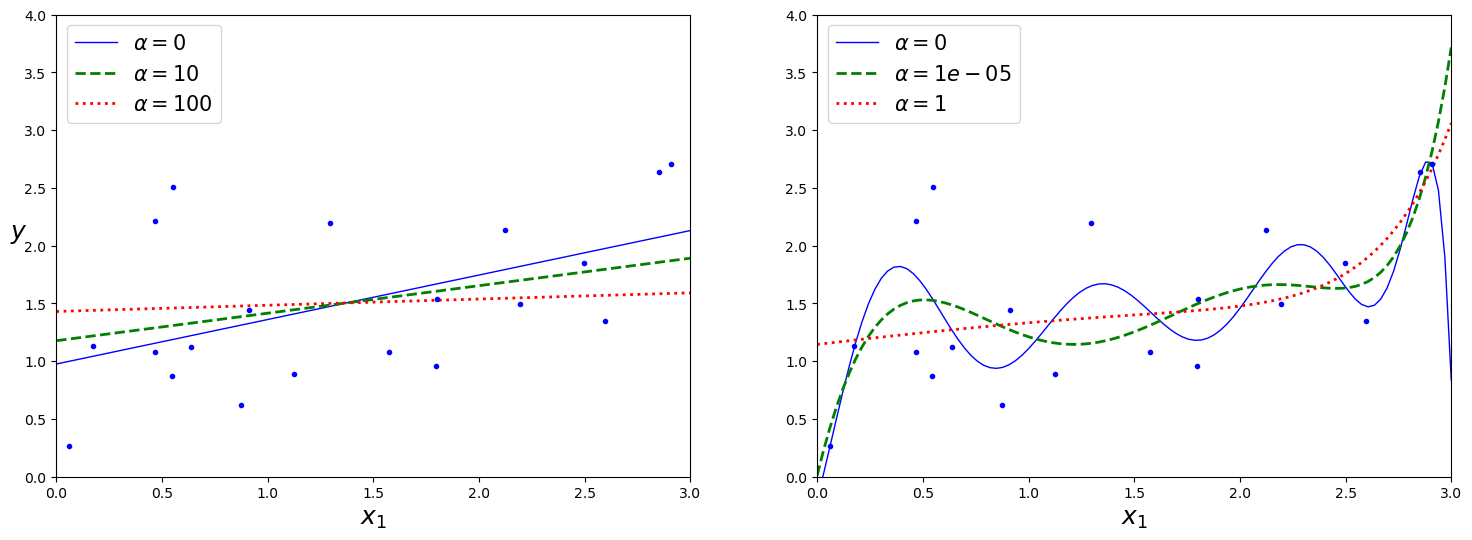

In [16]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(18,6))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.show()

On the left, we apply Ridge regressions with varying `alpha` using only the feature X that actually explains the data. On the right, we use the sklearn class `PolynomialFeatures` to generate features comprising the polynomials of X up to the 10th degree. Those features are standardized before the model is learned. We can clearly see that the learner now overfits the data if `alpha` is 0 or small, whereas the overfitting is reduced when `alpha` increases.

## Lasso Regression

Least Absolute Shrinkage and Selection Operator (Lasso) Regression  is a regularized version of the linear regression that uses the $\ell_1$ norm for the penalty term rather than the $\ell_2$ norm used for Ridge regressions. The cost function is
\begin{align}
J(\theta)=MSE(\theta)+\alpha\sum_{j=1}^m|\theta_j|
\end{align}
An important difference between Lasso and Ridge regressions is that Lasso tends to set the weights of the least important features to 0 rather than some small value. Thus, Lasso automates __feature selection__ and creates a __sparse model__.

Lasso regressions do not have a closed-form solution. The cost function is not differentiable at $\theta_j=0$ either, such that the gradient does not exist. However, we can compute a __subgradient vector__ that is defined as

\begin{align}
g(\theta,J) = \nabla_{\theta}MSE(\theta)+\alpha
\begin{pmatrix}
\text{sign}(\theta_1) \\
\text{sign}(\theta_2) \\
\vdots\\
\text{sign}(\theta_m)
\end{pmatrix}
\text{ where sign}(\theta_j)=
\begin{pmatrix}
-1\text{ if }\theta_j<0 \\
0\text{ if }\theta_j=0 \\
1\text{ if }\theta_j>0 
\end{pmatrix}
\end{align}

`sklearn` implements Lasso regressions in the class `Lasso`. The below example, based on the same data we used for the Ridge regression, shows that the learned functions appear similar, but it suggests that more of the polynomial terms are eliminated when `alpha` is increased.

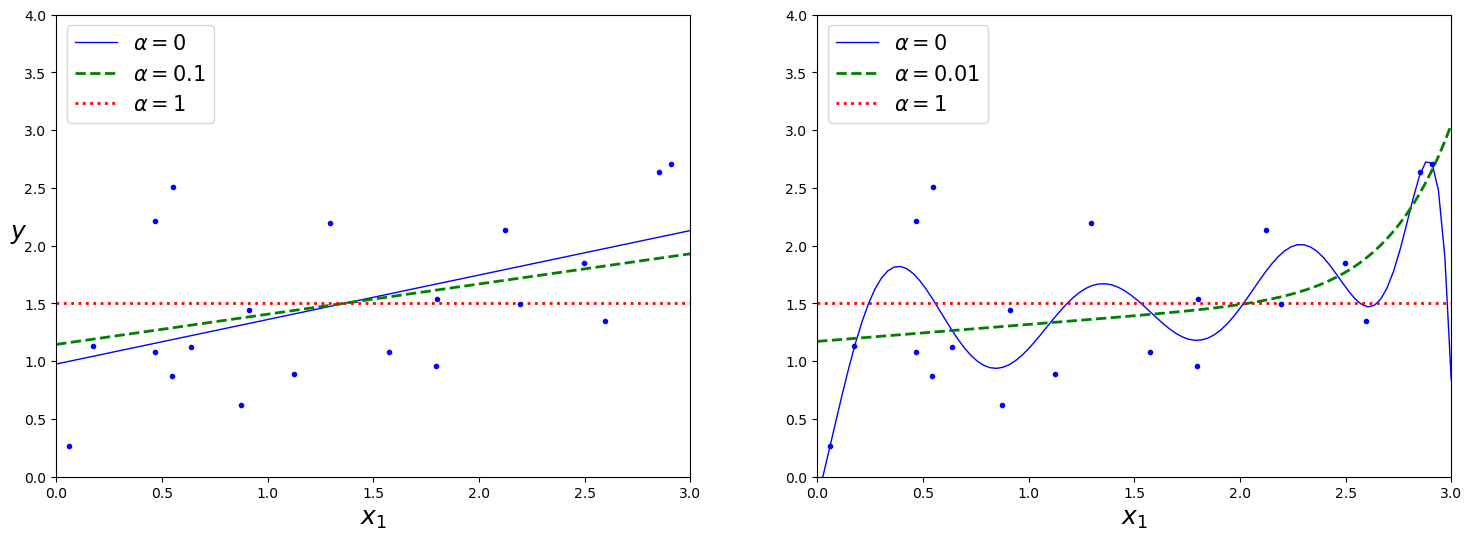

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-2, 1), random_state=42)
plt.show()

## Comparing Ridge and Lasso

In [18]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

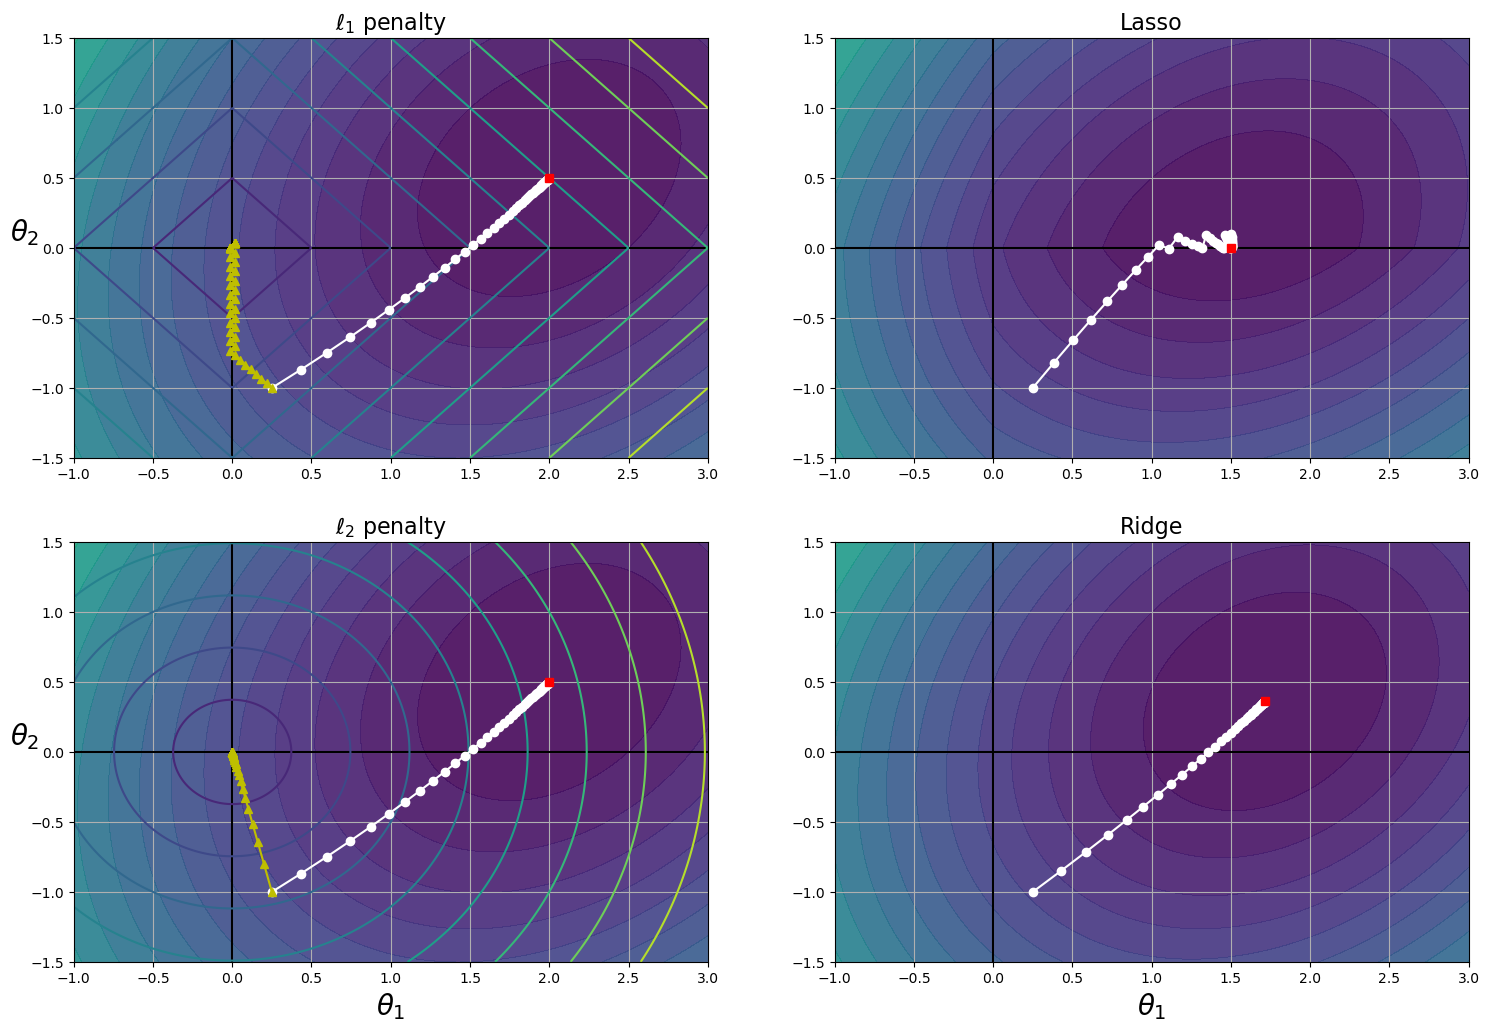

In [19]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(18, 12))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        plt.xlabel(r"$\theta_1$", fontsize=20)

plt.show()

The figures show, on the left, the paths toward the optimum if only the regression fit or only the penalty term are minimized through Batch Gradient Descent. On the right, we can see the path to the optimum for the Lasso and Ridge regressions, respectively. It is apparent that for Lasso, the parameter $\theta_2$ for the less important feature goes to 0, whereas for Ridge, the parameters shrink but don't go to 0.

## Elastic Net

Elastic Net regressions include both $\ell_1$ and $\ell_2$ penalty terms in the cost function. The relative importance of each term is determined by the ratio $r$: if $r=0$, Elastic Net is identical to Ridge regression; if $r=1$, it is identical to Lasso regression. The cost function is defined as

\begin{align}
J(\theta)=MSE(\theta)+r\alpha\sum_{j=1}^m|\theta_j|+\frac{1-r}{2}\alpha\sum_{j=1}^m\theta_j^2
\end{align}

sklearn contains the class `ElasticNet` that we apply to the previously created data here.

In [20]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early stopping

An alternative approach to regularization is to stop learning when the __validation error__ reaches its minimum. The validation error here is defined as the error for a validation set that shouldn't be identical to the test set that will ultimately be used to evaluate the performance of the learner.

If we use Batch Gradient Descent, we can be confident that the fit will improve with each epoch, whereas that is uncertain for Stochastic Gradient Descent, such that we shouldn't stop immediately as soon as the performance slightly decreases.

The `SGDRegressor` includes a parameter `early_stopping` that applies early stopping, and a parameter `validation_fraction` determining the fraction of the data to be used for the validation. The code below trains a linear regression with early stopping. We do not apply a varying `learning_rate`, nor do we stop if the fit of the training data has stopped improving beyond some tolerance `tol`.

In [21]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [22]:
model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("reg", SGDRegressor(tol=None, penalty=None, random_state=42,
                learning_rate="constant", eta0=0.0005,
                early_stopping=True, validation_fraction=0.5, max_iter=500)),
                ])
model.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.38390205])

To illustrate the process of improving fit and early stopping, we implement the process manually and produce a graph.

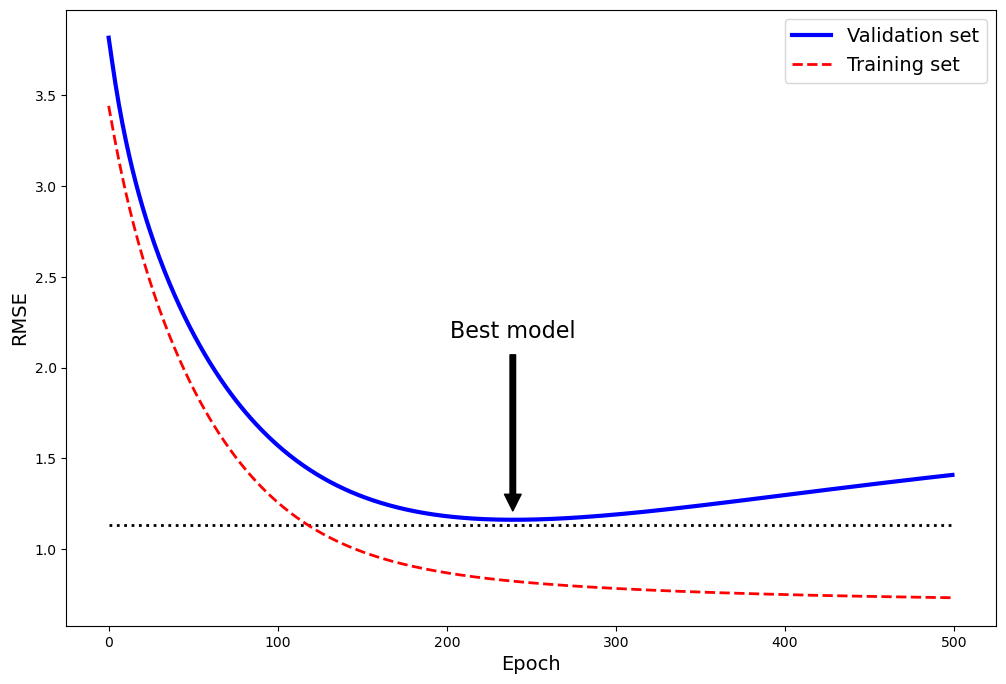

In [23]:
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.figure(figsize=(12, 8))
plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# Logistic regression

Logistic regression can be used both for classification and regression tasks. In the latter case, it predicts a probability. The estimated probability is the value of the __logistic sigmoid function__ of an expression that is linear in the features. It is defined as

\begin{align}
\hat{p}&=h_{\theta}(\mathbf{x})=\phi\big(\theta^T\mathbf{x}\big)
\end{align}
where
\begin{align}
\phi(z)&=\frac{1}{1+\exp(-z)}
\end{align}

The figure below plots the logistic as a function of z

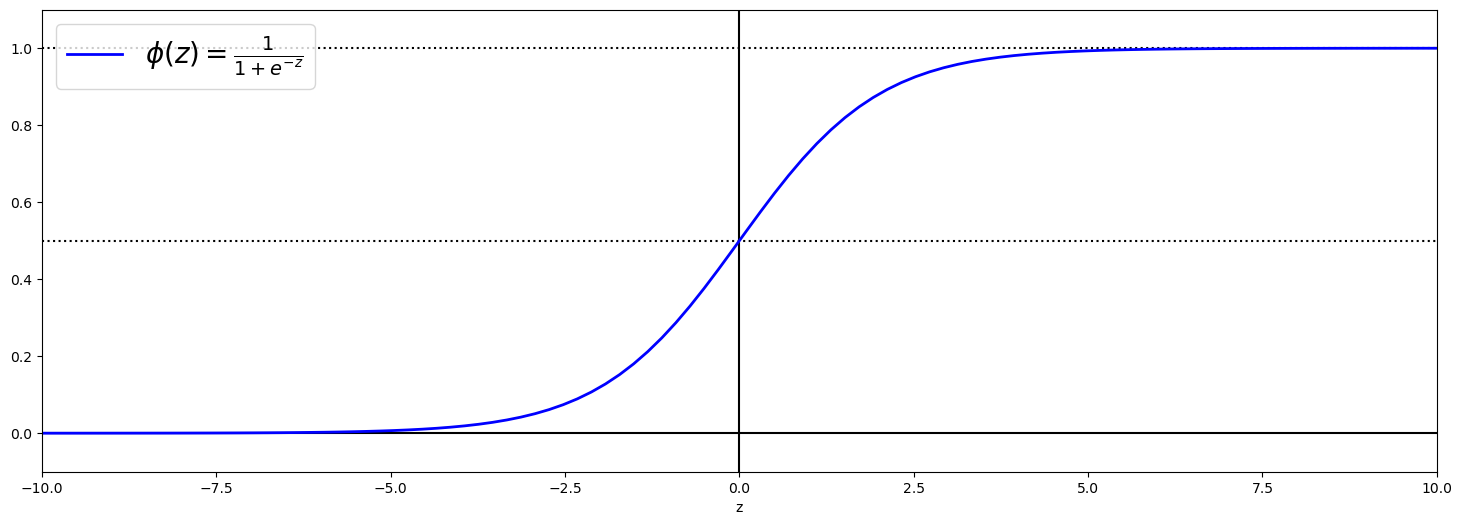

In [24]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(18, 6))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\phi(z) = \frac{1}{1 + e^{-z}}$")
plt.xlabel("z")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In a classification task, it is natural to predict

\begin{align}
\hat{y}=
\begin{cases}
0\text{ if }\hat{p}<0.5\\
1\text{ if }\hat{p}\geq0.5
\end{cases}
\end{align}
which is equivalent to

\begin{align}
\hat{y}=
\begin{cases}
0\text{ if }\hat{\theta^T}\mathbf{x}<0\\
1\text{ if }\hat{\theta^T}\mathbf{x}\geq0
\end{cases}
\end{align}

<center>

<img src="images/03_03.png" align="center" width="1200" />
</center>
(Raschka, ch 3)

## Cost function

The cost function of the logistic regression is the negative of the log-likelihood, here divided by the number of samples to obtain the average cost for each sample

\begin{align}
J(\theta)=-\frac{1}{n}\sum_{i=1}^n\Big[y^{(i)}\log\big(\hat{p}^{(i)}\big)+\big(1-y^{(i)}\big)\log\big(1-\hat{p}^{(i)}\big)\Big]
\end{align}

There is no closed-form solution to a logistic regression, but the cost function is convex, such that Gradient Descent is guaranteed to find the global minimum of the cost function. The partial derivative with respect to $\theta_j$ is

\begin{align}
\frac{\partial}{\partial\theta_j}J(\theta)=\frac{1}{n}\sum_{i=1}^n\Big(\phi\big(\theta^T\mathbf{x}^{(i)}\big)-y^{i}\Big)x_j^{(i)}
\end{align}

This expression looks very similar to that we have seen for OLS regressions or the Adaline.

The cost function can be changed to estimate regularized logistic regressions analogous to the case of linear regressions.

We will return to the iris data set to illustrate logistic regression. We set the target value for one of the three types of irises to 1, and to 0 for the others.

In [25]:
iris = datasets.load_iris()

X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(int)  # 1 if Iris virginica, else 0

sklearn offers the class `LogisticRegression`. By default, the `fit` method estimates a Ridge regression. That behavior can be changed by setting the parameter `penalty` to a different value. The strength of the penalty can be modified via the hyperparameter `C`, which is the inverse of the hyperparameter $\alpha$ of the Ridge, Lasso, or Elastic Net regression.

In [26]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

We use the method `predict_proba` to obtain the probabilities of the target value being 1, and plot how the probability depends on the feature we used.

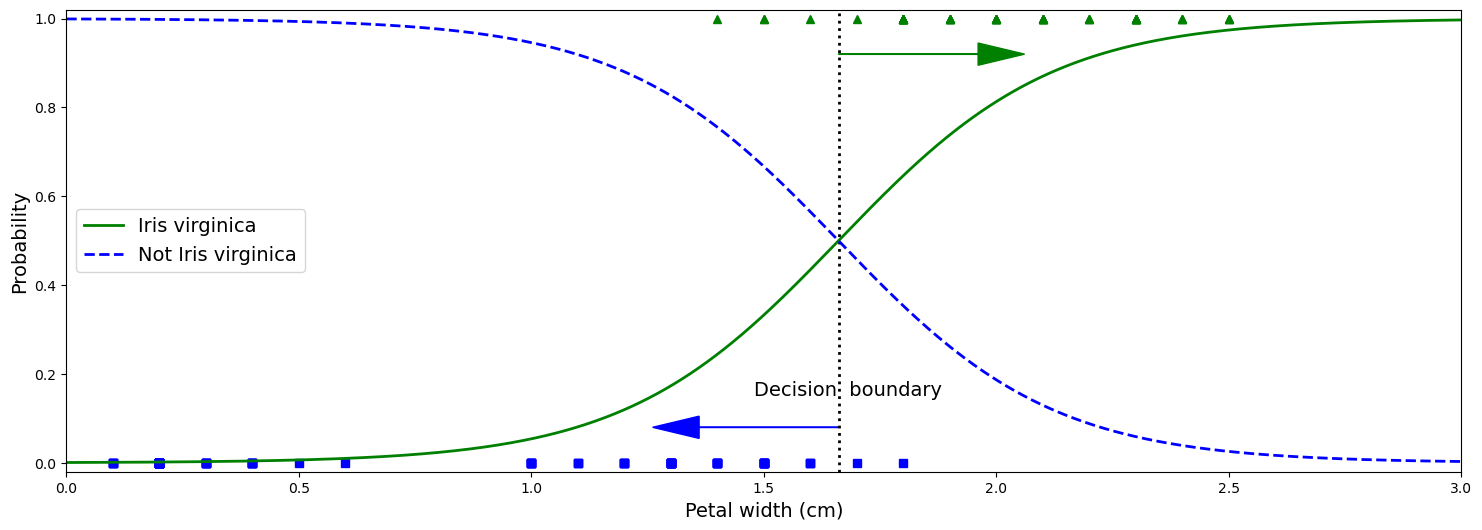

In [27]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(18, 6))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

The __decision boundary__ is the value of the feature, or more generally consists of the combinations of values of the features, at which the prediction changes from 0 to 1.

In [28]:
decision_boundary

array([1.66066066])

In [29]:
log_reg.predict_proba([[1.7], [1.5]])

array([[0.45722097, 0.54277903],
       [0.66709636, 0.33290364]])

In [30]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

## Performance measures for classification tasks

There are several ways to measure the performance of classifiers. 

Note that while we use the whole data set here to compute the performance measure, in practice, it is important to compute them separately for the training and the test data.

We have seen the confusion matrix before.

In [31]:
y_pred = log_reg.predict(X)
confusion_matrix(y,y_pred)

array([[98,  2],
       [ 4, 46]], dtype=int64)

The __accuracy__ score gives the percentage of correctly classified samples.

In [32]:
accuracy_score(y,y_pred)

0.96

__True positives__ are samples correctly predicted to belong to class 1, __false positives__ those incorrectly predicted to belong to class 1. __True negatives__ are samples correctly predicted not to belong to class 1, __false negatives__ those incorrectly predict not to belong to class 1.

If there are TP true positives and FP false positives, __Precision__ is defined as

\begin{align}
\text{precision}=\frac{TP}{TP+FP}
\end{align}

In [33]:
precision_score(y,y_pred)

0.9583333333333334

If there are FN false negatives, __recall__ is defined as

\begin{align}
\text{recall}=\frac{TP}{TP+FN}
\end{align}

In [34]:
recall_score(y,y_pred)

0.92

The __$F_1$score__ is defined as the harmonic mean of precision and recall.

\begin{align}
F_1=2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}
\end{align}

In [35]:
f1_score(y,y_pred)

0.9387755102040817

A __precision recall curve__ shows the tradeoff between precision and recall. To compute it, we first compute the predicted probabilities for each class.

In [36]:
y_scores = log_reg.predict_proba(X)
y_scores[:5]

array([[0.99821774, 0.00178226],
       [0.99821774, 0.00178226],
       [0.99821774, 0.00178226],
       [0.99821774, 0.00178226],
       [0.99821774, 0.00178226]])

The probabilities for class 1 are contained in column 1. We call the function `precision_recall_curve` to get the combinations of precision and recall for different thresholds, i.e., values of the decision boundary.

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

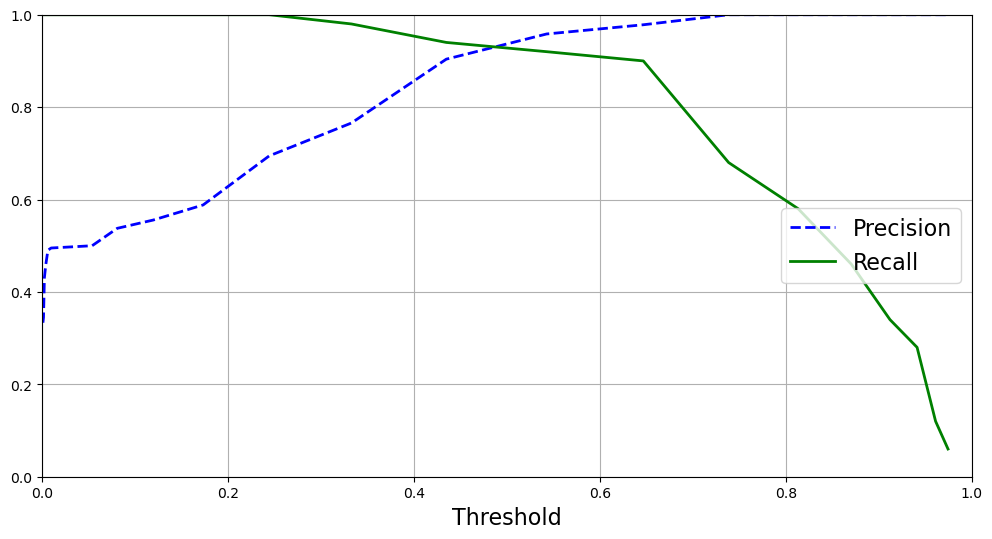

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                            
    plt.axis([0, 1, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
plt.figure(figsize=(12, 6))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The plot shows the tradeoff between precision and recall. E.g, if precision is relatively more important, it makes sense to shift the threshold to the left.

A different way to look at the tradeoff is to plot the precision against the recall.

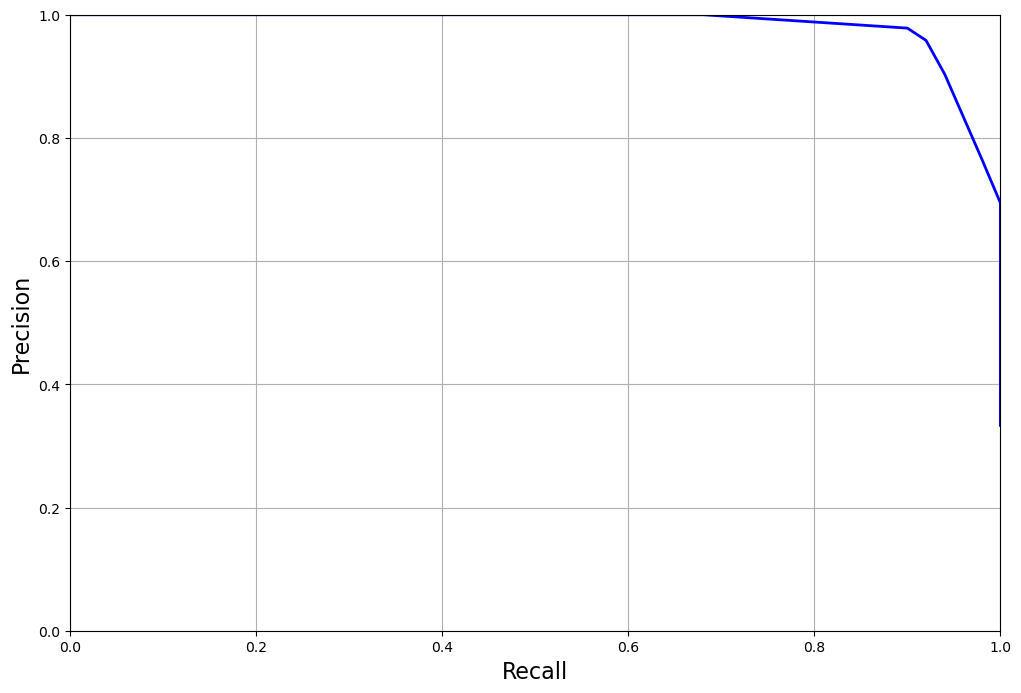

In [39]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(12, 8))
plot_precision_vs_recall(precisions, recalls)
plt.show()

Another frequently used tool for the performance evaluation of binary classifiers is the __receiver operating characteristics (ROC)__ curve. It plots the true positive rate, i.e., recall, against the false positive rate (FPR), i.e., $\frac{FP}{TN+FP}$.

The FPR is one minus the true negative rate (TNR), i.e., $\frac{TN}{TN+FP}$, which is also called __specificity__.

In [40]:
fpr, tpr, thresholds = roc_curve(y, y_pred)

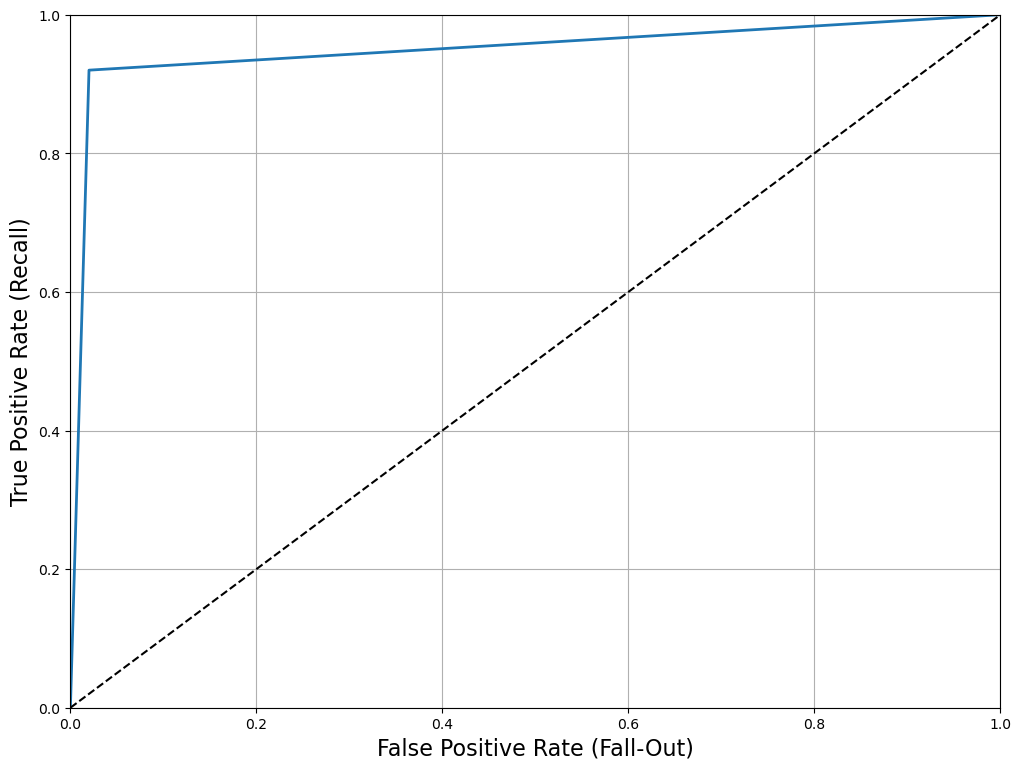

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                 
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(12, 9))                         
plot_roc_curve(fpr, tpr)
plt.show()

The __ROC area under the curve__ or __ROC AUC__, is another performance measure. A perfect classifier achieves a ROC AUC of 1, whereas a completely random classifier is expected to have a ROC AUC of $0.5$.

In [42]:
roc_auc_score(y, y_pred)

0.95

### Multivariate logistic regression

We estimate another logistic regression, this time using two features, to illustrate the decision boundary, which consists of a line in the two-dimensional space, for this case.

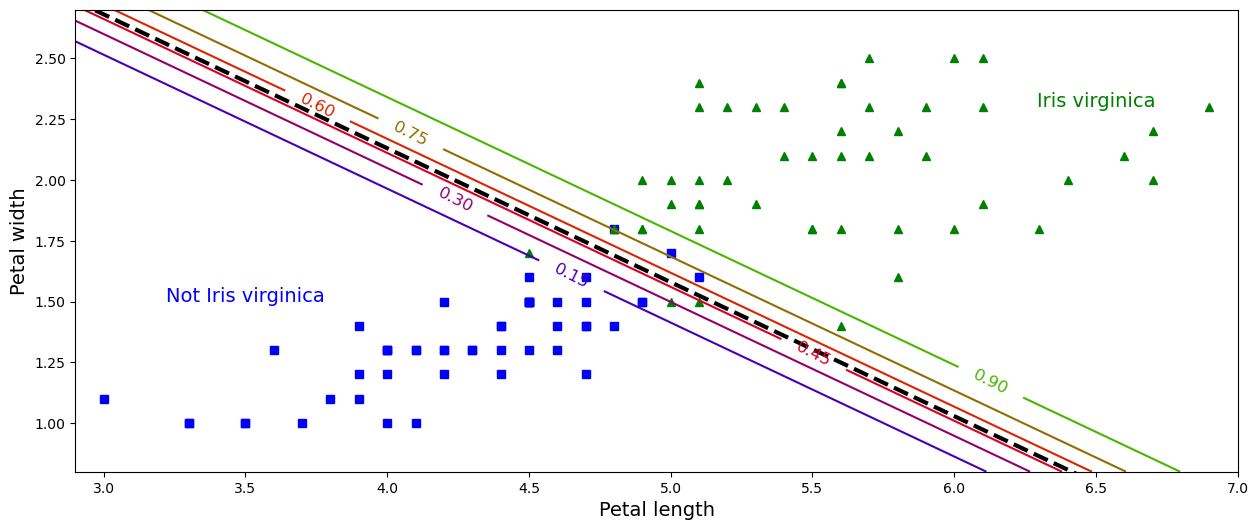

In [43]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(15, 6))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

## Multinomial logistic regression

The multinomial logistic regression (also called Softmax regression) generalizes the logistic regression to more than two classes of the categorical target variable. For each of the $K$ classes, there is a separate parameter vector $\theta_k$ that determines the score $s_k(\mathbf{x})$ of each class

\begin{align}
s_k(\mathbf{x})=\theta_k^T\mathbf{x}
\end{align}

If $s(\mathbf{x})$ is the vector containing the scores of each class for the feature vector $\mathbf{x}$, the probability of a sample belonging to class $k$ is

\begin{align}
\hat{p}_k= \phi(s_k(\mathbf{x}))=\frac{\exp\big(s_k(\mathbf{x})\big)}{\sum_{q=1}^K\exp\big(s_q(\mathbf{x})\big)}
\end{align}

The multinomial logistic classifier then predicts the class with the highest probability, which is the class with the highest score.

The cost function, called the __cross entropy__, is similar to that for the binary logistic regression. With $\Theta$ the matrix of parameters for all classes and $y^{(i)}_k=1$ if the target class of sample $i$ is $k$ and $y^{(i)}_k=0$ otherwise, the cost function is defined as

\begin{align}
J(\Theta)=-\frac{1}{n}\sum_{i=1}^n\sum_{k=1}^Ky^{(i)}_k\log\big(\hat{p}_k^{(i)}\big)
\end{align}

The gradient vector for class k is then

\begin{align}
\nabla_{\theta_k}J(\Theta)=\frac{1}{n}\sum_{i=1}^n\big(\hat{p}_k^{(i)}-y_k^{(i)}\big)x^{(i)}
\end{align}

Multinomial logistic regression is available in sklearn through the class `LogisticRegression` with the parameter `multi_class="multinomial"`. Without that parameter, `LogisticRegression` applies OvR (One-versus-rest) if there are more than two classes of the target.

As for the binary logistic regression, the multinomial logistic regression is, by default, estimated as a Ridge regression, i.e., the penalty term is added to the equations above.

We apply the multinomial logistic regression to the iris data set, using all three classes of the target.

In [44]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

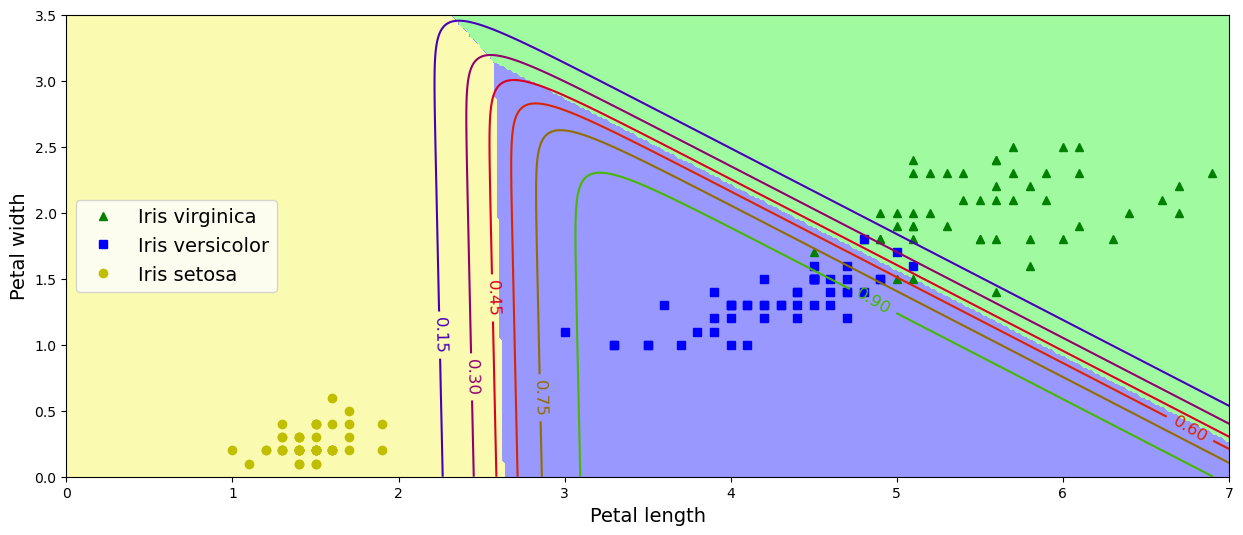

In [45]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(15, 6))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

The decision boundaries are linear combinations of the features. It is important to note that, if there are more than two classes, the predicted class can have a probability of less than 50 percent, as in the example below.

In [46]:
softmax_reg.predict([[2.6, 3]])

array([1])

In [47]:
softmax_reg.predict_proba([[2.6, 3]])

array([[0.39029691, 0.43096385, 0.17873924]])